In [9]:
import torch 
from torch import nn 
from torch.nn import functional as F
import time 
import matplotlib.pyplot as plt

from dataclasses import dataclass

from torch.utils.data import TensorDataset, DataLoader

In [10]:
@dataclass 
class Config:
    inputSize: int = 1 
    numEpochs: int = 15 
    miniBatchSize: int = 100 
    initialLearnRate: float = 0.5 
    learnRateDropFactor: float = 0.5 
    learnRateDropPeriod: int = 5 
    momentum: float = 0.9 
    icCoeff: int = 7 

class ODENet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config 
        self.layers = nn.Sequential(
            nn.Linear(config.inputSize, 10),
            nn.Sigmoid(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x


In [11]:
def modelGradients(model, x, icCoeff):
    # Convert data to PyTorch tensors and move to device.
    x = x.unsqueeze(1).float()
    device = x.device
    model.to(device)

    # Enable autograd.
    x.requires_grad_(True)

    # Forward pass.
    y = model(x)

    # Compute the gradient of y with respect to x.
    dy = torch.autograd.grad(outputs=y, inputs=x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

    # Define ODE loss.
    eq = dy + 2*y*x

    # Define initial condition loss.
    ic = model(torch.tensor([[0.0]], device=device)) - torch.tensor([[1.0]], device=device)

    # Specify the loss as a weighted sum of the ODE loss and the initial condition loss.
    loss = torch.mean(eq**2) + icCoeff * torch.mean(ic**2)

    # Compute model gradients.
    gradients = torch.autograd.grad(loss, model.parameters(), create_graph=True)

    return gradients, loss

In [12]:
config = Config()

model = ODENet(config)

x = torch.arange(0, 2, 1e-5)

dataset = TensorDataset(x)

dataloader = DataLoader(dataset, batch_size=config.miniBatchSize, shuffle=True)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=config.initialLearnRate, momentum=config.momentum, nesterov=True)

iteration = 0
learnRate = config.initialLearnRate
start = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

losses = []
iterations = []

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config.learnRateDropPeriod, gamma=config.learnRateDropFactor)

In [13]:
# Loop over epochs.
for epoch in range(config.numEpochs):

    # Loop over mini-batches.
    for batch_idx, (inputs,) in enumerate(dataloader):

        iteration += 1

        # Evaluate the model gradients and loss using the modelGradients function.
        gradients, loss = modelGradients(model, inputs, config.icCoeff)

        # Update network parameters using the optimizer.
        optimizer.zero_grad()
        for i, param in enumerate(model.parameters()):
            param.grad = gradients[i]
        optimizer.step()

        # Convert the loss to a scalar value.
        loss = loss.item()

        # Store the loss value.
        losses.append(loss)
        iterations.append(iteration)

    # Reduce the learning rate.
    scheduler.step()

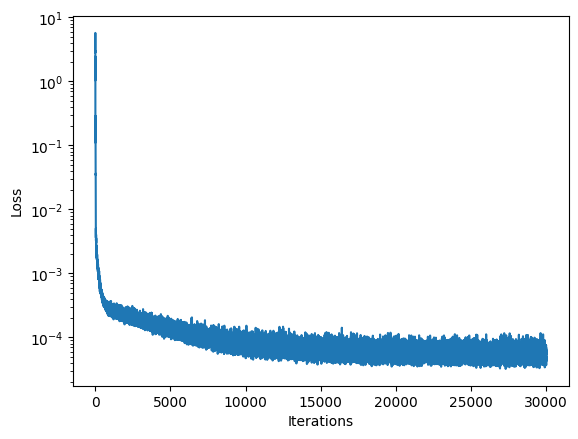

In [14]:
plt.plot(iterations, losses)
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [15]:
def modelPredictions(model, dataloader):
    """
    Computes the output predictions of the neural network model for a given input data loader.

    Parameters:
    - model: a PyTorch neural network model.
    - dataloader: a PyTorch DataLoader object representing the input data.

    Returns:
    - yModel: a PyTorch tensor representing the output predictions of the neural network model for the input dataset.
    """

    y_model = []

    # Set the model to evaluation mode.
    model.eval()

    with torch.no_grad():

        for (inputs,) in dataloader:

            inputs = inputs.unsqueeze(1).float()
            inputs = inputs.to(device)
            # Predict output using trained network.
            y = model(inputs)
            y_pred = y.cpu().flatten()

            y_model.append(y_pred)

    y_model = torch.cat(y_model)

    return y_model


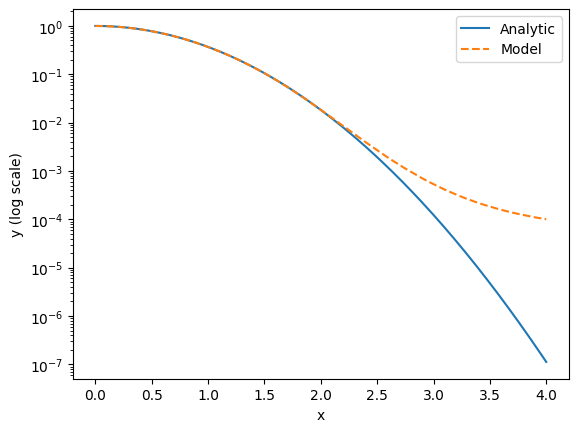

In [16]:
x_test = torch.arange(0, 4, 1e-5)

dataset_test = TensorDataset(x_test)

dataloader_test = DataLoader(dataset_test, batch_size=config.miniBatchSize, shuffle=False)

yModel = modelPredictions(model, dataloader_test)

yAnalytic = torch.exp(-x_test.pow(2))

# Plot analytic and model predictions.
plt.figure()
plt.plot(x_test.numpy(), yAnalytic.numpy(), '-', label='Analytic')
plt.plot(x_test.numpy(), yModel, '--', label='Model')

# Set plot labels and legend.
plt.xlabel('x')
plt.ylabel('y (log scale)')
plt.yscale('log')
plt.legend()

# Show plot.
plt.show()


In [17]:
# create PyTorch tensors for yModel and yAnalytic
yModel = torch.Tensor(yModel)
yAnalytic = torch.Tensor(yAnalytic)

# select the first 500 elements of yModel and yAnalytic
yModelTrain = yModel[:500]
yAnalyticTrain = yAnalytic[:500]

# calculate the error between yModelTrain and yAnalyticTrain
errorTrain = ((yModelTrain - yAnalyticTrain) / yAnalyticTrain).pow(2).mean().item()


In [18]:
# create PyTorch tensors for yModel and yAnalytic
yModel = torch.Tensor(yModel)
yAnalytic = torch.Tensor(yAnalytic)

# select the elements 501 to 1000 of yModel and yAnalytic
yModelExtra = yModel[500:1000]
yAnalyticExtra = yAnalytic[500:1000]

# calculate the error between yModelExtra and yAnalyticExtra
errorExtra = ((yModelExtra - yAnalyticExtra) / yAnalyticExtra).pow(2).mean().item()

In [19]:
print("Training error: {:.2e}".format(errorTrain))
print("Extra error: {:.2e}".format(errorExtra))

Training error: 4.06e-06
Extra error: 4.84e-06
